<a href="https://colab.research.google.com/github/phipi-a/tu-berlin-aal/blob/master/selector_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
https://gitlab-edu.aot.tu-berlin.de/ws20-aal/group-1/-/blob/eingabeanalyse/nn-training/eingabeanalyse/nn-training/device_selector_training.ipynb


#import, load spacy model

In [ ]:
!pip install spacy==2.3.5

In [ ]:
!pip install cyhunspell

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Input, MaxPooling1D, Flatten, Bidirectional, GRU, BatchNormalization ,SimpleRNN, RNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import losses
from tensorflow.keras import backend as K
import spacy
import re
from sklearn.model_selection import train_test_split
from tensorflow import keras
from hunspell import Hunspell
import tensorflow as tf
import random
import json
import os
import sys
import zipfile
import shutil
import glob
from sklearn.utils import class_weight as cw

In [ ]:
try:
    nlp_german = spacy.load('de_core_news_lg')
except OSError:
    print('Downloading language model\n')
    from spacy.cli import download
    download('de_core_news_lg')
    nlp_german = spacy.load('de_core_news_lg')

# load data

In [ ]:
def one_hot_encoding(l, ncl):
    t = np.zeros(ncl)
    t[l] = 1
    return t


def listToIndexLookup(actions):
    ret = {}
    for idx, action in enumerate(actions):
        ret[action] = idx
    return ret

In [ ]:
dir_of_datasets="/content/drive/MyDrive/aal/action_selector/"
hunspell = Hunspell("de_DE", hunspell_data_dir="/content/drive/MyDrive/aal/res")

In [ ]:
with open("/content/drive/MyDrive/aal/res/spacy_missing_vectors.json") as jf:
    data_v=json.load(jf)
    nlp_german.vocab.vectors.resize((500000+len(data_v), 300))
    for word in data_v:
      if word["missing_word"]=="":
        continue
      nlp_german.vocab.vectors.add(word["missing_word"],vector=nlp_german.vocab.get_vector(nlp_german.vocab.strings[word["matching_word"]]))

In [ ]:
directions_of_datasets=glob.glob(dir_of_datasets+"*.zip")
config_file_dirs=list()
for zipfile_dir in directions_of_datasets:
  try:
    shutil.rmtree(zipfile_dir.replace(".zip",""))
  except FileNotFoundError:
    pass
  os.mkdir(zipfile_dir.replace(".zip",""))
  shutil.unpack_archive(zipfile_dir, zipfile_dir.replace(".zip",""))
  config_file_dirs.append(zipfile_dir.replace(".zip","")+"/config.json")

In [ ]:
def load_config(file_dirs):
  spacy_version=None
  language_model=None
  POS_LOOKUP=None
  x_vector_length=None
  Y_VALUE_LOOKUP=None
  for file_path in file_dirs:
    print("open config file:",file_path)
    with open(file_path) as json_file:
        data = json.load(json_file)
        if spacy_version ==None:
          spacy_version=data["spacy"]["spacy_version"]
          if spacy.__version__==spacy_version:
            print("spacy_version: ok")
          else:
            print("incorrect spacy version loaded")
            exit()
          language_model = data["spacy"]["language_model"]
          print("language_model: "+language_model)
          POS_LOOKUP = listToIndexLookup(data["spacy"]["valid_pos_tags"])
          x_vector_length = nlp_german.vocab.vectors_length + np.sum([len(a["elements"]) for a in data["x"]["element_vector_additional_content"]]) + len(data["spacy"]["valid_pos_tags"])
          ADD_CONTENT_LOOKUP = {}
          for add_content in data["x"]["element_vector_additional_content"]:
              ADD_CONTENT_LOOKUP[add_content["element_json_name"]] = listToIndexLookup(add_content["elements"])
          Y_VALUE_LOOKUP = listToIndexLookup(data["y"]["elements"])
          
        else:
          if spacy_version!=data["spacy"]["spacy_version"]:
            print("spacy_version not compatibel")
            return(False)
          if language_model!=data["spacy"]["language_model"]:
            print("language_model not compatibel")
            return(False)
          if POS_LOOKUP!=listToIndexLookup(data["spacy"]["valid_pos_tags"]):
            print("POS_LOOKUP not compatibel")
            return(False)
          if x_vector_length!=nlp_german.vocab.vectors_length + np.sum([len(a["elements"]) for a in data["x"]["element_vector_additional_content"]]) + len(data["spacy"]["valid_pos_tags"]):
            print("x_vector_length not compatibel")
            return(False)
          if Y_VALUE_LOOKUP!=listToIndexLookup(data["y"]["elements"]):
            print("Y_VALUE_LOOKUP not compatibel")
            return(False)
  return True

In [ ]:
print(config_file_dirs)
if load_config(config_file_dirs):
  with open(config_file_dirs[0]) as json_file:
          data = json.load(json_file)
          X_VECTOR_LENGTH=nlp_german.vocab.vectors_length + np.sum([len(a["elements"]) for a in data["x"]["element_vector_additional_content"]]) + len(data["spacy"]["valid_pos_tags"])
          POS_LOOKUP=listToIndexLookup(data["spacy"]["valid_pos_tags"])
          Y_VALUE_LOOKUP=listToIndexLookup(data["y"]["elements"])
          Y_VALUE_LOOKUP=listToIndexLookup(data["y"]["elements"])
          ADD_CONTENT_LOOKUP = {}
          for add_content in data["x"]["element_vector_additional_content"]:
              ADD_CONTENT_LOOKUP[add_content["element_json_name"]] = listToIndexLookup(add_content["elements"])
          print("datasets: ok")

['/content/drive/MyDrive/aal/action_selector/device_selector_dataset_from_actions/config.json']
open config file: /content/drive/MyDrive/aal/action_selector/device_selector_dataset_from_actions/config.json
spacy_version: ok
language_model: de_core_news_lg
datasets: ok


In [ ]:
Xdata = np.concatenate([np.load(a.replace("config.json","x_data.npy")) for a in config_file_dirs])
Ydata = np.concatenate([np.load(a.replace("config.json","y_data.npy")) for a in config_file_dirs])

#Definitions

In [ ]:
def check(word):
    old_word = word
    if nlp_german.vocab.has_vector(word):
        return word
    if nlp_german.vocab.has_vector(word.capitalize()):
        return word.capitalize()
    if word.strip() == "":
        return ""

    if not hunspell.spell(word):
        word_suggest = hunspell.suggest(word)
        if len(word_suggest) == 0:
            return old_word
        word = word_suggest[0]

    if nlp_german.vocab.has_vector(word):
        return word
    if nlp_german.vocab.has_vector(word.capitalize()):
        return word.capitalize()

    hunspell_analysis = hunspell.analyze(word)

    if len(hunspell_analysis) == 0:
        if not nlp_german.vocab.has_vector(word):
            return old_word
        return word
    hunspell_analysis = hunspell_analysis[0]

    stam_list = re.findall(" [A-Za-zÀ-ž\u0370-\u03FF\u0400-\u04FF]*:[A-Za-zÀ-ž\u0370-\u03FF\u0400-\u04FF]*", hunspell_analysis)

    for stam in stam_list:
        stam_string = stam.split(":")[1]
        if len(stam_string) >= 3:
            parts = re.split(stam_string, word, flags=re.IGNORECASE)
            if len(parts) == 0 or len(parts) == 1 and len(parts[0]) == len(word):
                continue
            if not hunspell.spell(stam_string):
                stam_string = hunspell.suggest(stam_string)[0]
            return (check(parts[0]) + " " + stam_string + " " + check(parts[1])).strip()
    return word



In [ ]:

def string_preprocessing(sentence):
    sentence=sentence.lower()
    missing_words_after_check = list()
    word_list = sentence.replace(".", "").replace("!", "").replace("?", " ").replace(",", " ").split(" ")
    new_text = ""
    for word in word_list:
        if word == "":
            continue
        try:
            new_word = check(word)
        except UnicodeEncodeError as e:
            print(word)
            print("json_unicode_encode_error_error")
        new_text = new_text + " " + new_word
        for x in new_word.split(" "):
            if not nlp_german.vocab.has_vector(x):
                missing_words_after_check.append(word)
                print(sentence)
    return missing_words_after_check,new_text.strip()

In [ ]:
def processSample(sample):
    _,new_input = string_preprocessing(sample[data["x"]["element_json_name"]])
    doc = nlp_german(new_input)

    if len(doc) > data["x"]["maxword_length"]:
        return False, None, None

    sample_x = np.empty(shape=[0, int(X_VECTOR_LENGTH)])
    for tag in doc:
        if tag.pos_ in data["spacy"]["forbidden_pos_tags"]:
            continue

        lemma_tag = nlp_german(tag.lemma_)[0]

        pos = one_hot_encoding(POS_LOOKUP[tag.pos_], len(data["spacy"]["valid_pos_tags"]))
        if not lemma_tag.has_vector:
            if tag.has_vector:
                lemma_tag=tag
            else:
                print(tag)
        t = np.concatenate([lemma_tag.vector, pos])
        for add_content in data["x"]["element_vector_additional_content"]:
            add_content_vector = one_hot_encoding(
                ADD_CONTENT_LOOKUP[add_content["element_json_name"]][sample[add_content["element_json_name"]]],
                len(add_content["elements"]))
            t = np.append(t, add_content_vector)

        sample_x = np.append(sample_x, [t], axis=0)
            # fill up rest
    while len(sample_x) < data["x"]["maxword_length"]:
        sample_x = np.append(sample_x, [np.zeros(int(X_VECTOR_LENGTH))], axis=0)

    return True, sample_x


In [ ]:
# your class labels
classes = list(Y_VALUE_LOOKUP.keys())

class AccuracyCallback(tf.keras.callbacks.Callback):

    def __init__(self, test_data):
        self.test_data = test_data
        self.class_history = list()
        for i in classes:
           self.class_history.append(list())
        self.accuracy = []
        self.val_accuracy = []

    def on_batch_end(self, batch, logs={}):
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

    def on_epoch_end(self, epoch, logs=None):
        x_data, y_data = self.test_data

        correct = 0
        incorrect = 0

        x_result = self.model.predict(x_data, verbose=0)

        x_numpy = []

        class_correct = [0] * len(classes)
        class_incorrect = [0] * len(classes)

        for i in range(len(x_data)):
            x = x_data[i]
            y = y_data[i]

            res = x_result[i]

            actual_label = np.argmax(y)
            pred_label = np.argmax(res)

            if(pred_label == actual_label):
                x_numpy.append(["cor:", str(y), str(res), str(pred_label)])     
                class_correct[actual_label] += 1   
                correct += 1
            else:
                x_numpy.append(["inc:", str(y), str(res), str(pred_label)])
                class_incorrect[actual_label] += 1
                incorrect += 1

        print("\tCorrect: %d" %(correct))
        print("\tIncorrect: %d" %(incorrect))

        for i in range(len(classes)):
            tot = float(class_correct[i] + class_incorrect[i])
            class_acc = -1
            if (tot > 0):
                class_acc = float(class_correct[i]) / tot
            self.class_history[i].append(class_acc)
            print("\t%s: %.3f" %(classes[i],class_acc)) 

        acc = float(correct) / float(correct + incorrect)  

        print("\tCurrent Network Accuracy: %.3f" %(acc))

#prepare training

In [ ]:
class_weightkit = cw.compute_class_weight('balanced',
                                                 np.unique(Ydata),
                                                 Ydata)
print(np.unique(Ydata))
print(class_weightkit)
class_weight = {0: class_weightkit[0],
                1: class_weightkit[1],
                2: class_weightkit[2],
                3: class_weightkit[3],
                4: class_weightkit[4],
                5: class_weightkit[5],
                6: class_weightkit[6],
                7: class_weightkit[7],
                8: class_weightkit[8],
                9: class_weightkit[9],
                10: class_weightkit[10],
                11: class_weightkit[11],
                12: class_weightkit[12],
                13: class_weightkit[13],
                14: class_weightkit[14],
                15: class_weightkit[15],
                16: class_weightkit[16],
                17: class_weightkit[17]}
print(class_weight)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.]
[ 0.70240089  1.37396243  3.59018265  1.09258294  1.87202381  0.52142916
  1.08298898  0.91597495  8.35325365  0.96799015 11.91287879  0.28460251
  0.42728076  2.66751484  0.82970584  0.72099954 14.36073059 16.64021164]
{0: 0.7024008933556672, 1: 1.3739624290083006, 2: 3.5901826484018264, 3: 1.0925829425047768, 4: 1.8720238095238095, 5: 0.5214291635579872, 6: 1.0829889807162534, 7: 0.9159749526722004, 8: 8.353253652058433, 9: 0.9679901508156356, 10: 11.912878787878787, 11: 0.28460250667390613, 12: 0.42728075538346577, 13: 2.6675148430873623, 14: 0.8297058435562591, 15: 0.7209995414947272, 16: 14.360730593607306, 17: 16.64021164021164}


###to_categorical train-test split

In [ ]:
i=100
print("Ydata value: ",Ydata[i])
Y_cat=keras.utils.to_categorical(Ydata,len(Y_VALUE_LOOKUP))
print("Ydata to_categorical value: ",Y_cat[i])
trainx, testx, trainy, testy = train_test_split(Xdata, Y_cat, test_size=0.33, random_state=42)

Ydata value:  12.0
Ydata to_categorical value:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


#Define Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 20, 40)            41040     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 18)                738       
Total params: 51,538
Trainable params: 51,538
Non-trainable params: 0
_________________________________________________________________


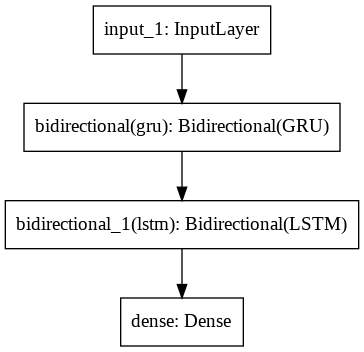

In [ ]:
model = Sequential()
model.add(Input(shape=(20, 300+20)))
model.add(Bidirectional(GRU(20,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(20,dropout=0.2)))
model.add(Dense(18,activation="softmax"))
model.build()
model.compile(
    optimizer=Adam(),
    loss=losses.categorical_crossentropy,metrics=['accuracy'])
 
model.summary()
plot_model(model)

#Training


In [ ]:
def augmentate(X_point):
  return X_point+np.random.normal(0,5,6340).reshape((20,317))



In [ ]:
def generator(X_data, y_data, batch_size):

  samples_per_epoch = X_data.shape[0]
  number_of_batches = samples_per_epoch/batch_size
  counter=0

  while 1:

    X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)])
    y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
    counter += 1
    yield X_batch,y_batch

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

In [ ]:
val_data=(np.asarray(testx),np.asarray(testy))
accuracy_callback = AccuracyCallback(val_data)
batch_size=512
history=model.fit_generator(generator(trainx, trainy, batch_size),steps_per_epoch = trainx.shape[0]/batch_size,epochs=30,callbacks=[accuracy_callback],shuffle=True,class_weight=class_weight,validation_data=val_data)

NameError: ignored

In [ ]:
len(trainx)

25285

In [ ]:
val_data=(np.asarray(testx),np.asarray(testy))
accuracy_callback = AccuracyCallback(val_data)
history=model.fit(callbacks=[accuracy_callback],x=np.asarray(trainx),y=np.asarray(trainy),batch_size=25285,epochs=100,shuffle=True,class_weight=class_weight,validation_data=val_data)

Epoch 1/100
1/1 [==============================] - 33s 33s/step - loss: 2.9349 - accuracy: 0.0564 - val_loss: 2.8622 - val_accuracy: 0.0953
	Correct: 1187
	Incorrect: 11268
	latte macchiato: 0.059
	hot milk: 0.061
	foam milk: 0.148
	tea & hot water: 0.005
	espresso: 0.064
	grill: 0.004
	machine care: 0.012
	cold milk: 0.005
	bread baking program: 0.010
	upper and lower heating: 0.000
	pizza program: 0.222
	coffee: 0.045
	upper heating: 0.471
	preheat: 0.054
	lower heating: 0.069
	air circulation: 0.061
	keepwarm: 0.000
	humiditycontrol: 0.070
	Current Network Accuracy: 0.095
Epoch 2/100
1/1 [==============================] - 17s 17s/step - loss: 2.9030 - accuracy: 0.0816 - val_loss: 2.8225 - val_accuracy: 0.1395
	Correct: 1737
	Incorrect: 10718
	latte macchiato: 0.057
	hot milk: 0.101
	foam milk: 0.203
	tea & hot water: 0.049
	espresso: 0.067
	grill: 0.043
	machine care: 0.032
	cold milk: 0.005
	bread baking program: 0.010
	upper and lower heating: 0.000
	pizza program: 0.200
	coffee: 

In [ ]:

z={}
Y_VALUE=list(Y_VALUE_LOOKUP.keys())
for k,h in enumerate(accuracy_callback.class_history[:-1]):
  z[Y_VALUE[k]]=h
history_big = dict(history.history)
history_big.update(z)
plot(history_big)

NameError: ignored

#test model


In [ ]:
def plot(history):
  fig, axs = plt.subplots(len(history)-len([ v for k,v in history.items() if 'val' in k]))
  fig.set_size_inches(18.5, 15.5)
  z=0
  for k in range(len(history)):
      key=list(history.keys())[k]
      if not "val_" in key:
        
        axs[z].plot(history[key], label=key)
        axs[z].legend(bbox_to_anchor=(1, 1), loc='upper left',)
        if "val_"+key in history:
          axs[z].plot(history["val_"+key], label="val_"+key)
          axs[z].legend(bbox_to_anchor=(1, 1), loc='upper left',)
        z=z+1
  

In [ ]:
print(Y_VALUE_LOOKUP)

{'coffee machine': 0, 'oven': 1, 'other': 2}


In [ ]:
_, sequence = processSample({
    "text": "halte für 10 min bitte mein essen warm",
    "device":"coffee machine"
})
print(sequence)
prediction=model.predict(sequence.reshape((1,data["x"]["maxword_length"],data["x"]["input_vector_length"])))
print(prediction)
print("predicted: ", data["y"]["elements"][np.argmax(prediction)]," | ", np.round(np.max(prediction),4))

[[ 2.22169995  0.5345     -1.22259998 ...  0.          1.
   0.        ]
 [ 1.73389995 -4.17059994  0.20804    ...  0.          1.
   0.        ]
 [ 1.74520004 -1.99860001  0.051256   ...  0.          1.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[5.6928907e-06 5.8005995e-04 3.6972084e-05 1.6289288e-03 2.3584002e-05
  7.2042138e-04 1.8706374e-06 2.7214803e-03 1.3203286e-05 1.2694033e-02
  7.2753173e-05 2.5007583e-04 2.7952410e-04 1.6398200e-04 2.3260254e-05
  3.9280047e-05 9.8055500e-01 1.8987409e-04]]
predicted:  keepwarm  |  0.9806


In [ ]:
check(spacy.__version__)

'2.3.5'

#save model

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model_weights=model.get_weights()
np.save('model_weights.npy', model_weights)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
